# **Imports**

In [54]:
import numpy as np
import pandas as pd
import time
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA


# **Modelo KNN**

In [44]:
from pickle import NONE
class KNearestNeighbors(BaseEstimator, ClassifierMixin):
    def __init__(self, X_train, y_train, n_neighbors=5, weights='uniform'):

        self.X_train = X_train
        self.y_train = y_train

        self.n_neighbors = n_neighbors
        self.weights = weights

        self.n_classes = 10
        self.prediction = NONE

    def euclidian_distance(self, a, b):
        return np.sqrt(np.sum((a - b)**2, axis=1))

    def kneighbors(self, X_test, return_distance=False):

        dist = []
        neigh_ind = []
        point_dist = []
        for x_test in X_test:
            point_dist += [ self.euclidian_distance(x_test, self.X_train) ]

        for row in point_dist:
            enum_neigh = enumerate(row)
            sorted_neigh = sorted(enum_neigh,
                                  key=lambda x: x[1])[:self.n_neighbors]

            ind_list = [tup[0] for tup in sorted_neigh]
            dist_list = [tup[1] for tup in sorted_neigh]

            dist.append(dist_list)
            neigh_ind.append(ind_list)

        if return_distance:
            return np.array(dist), np.array(neigh_ind)

        return np.array(neigh_ind)

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):

        if self.weights == 'uniform':
            neighbors = self.kneighbors(X_test)
            y_pred = np.array([
                np.argmax(np.bincount(self.y_train[neighbor]))
                for neighbor in neighbors
            ])
            return y_pred

        if self.weights == 'distance':
            distances, neighbors = self.kneighbors(X_test, return_distance=True)
            y_pred = np.array([
                np.argmax(np.bincount(self.y_train[neighbor], 1 / (distances[i] + 1e-6)))
                for i, neighbor in enumerate(neighbors)
            ])
            self.prediction = y_pred
            return y_pred


# **Modelo Árbol de Decisión**

# **Modelo Regresión Logística**

In [ ]:
class OurLogisticRegression (BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
       

    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        # weights initialization
        self.w = np.zeros(X.shape[1])

        for i in range(self.num_iter):
            z = np.dot(X, self.w)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h-y)) / y.size
            #print(gradient.shape, self.w.shape, z.shape,h.shape)
            #gradient = (h - y) / y.size
            self.w -= self.lr * gradient

    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        return self.__sigmoid(np.dot(X, self.w))

    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold
    
    def score(self, y_pred,y_test):
        return float(sum(y_pred == y_test)) / float(len(y_test))


# **Dataset WeatherAUS**

In [45]:
dataset_path = "weatherAUS.csv"
dataset = pd.read_csv(dataset_path)

#Eliminemos las filas que no tengan un RainTomorrow definido
dataset = dataset.dropna(subset=["RainTomorrow"])

# Eliminamos algunos features de texto que no representan mayor diferencia al realizar la aproximación y obteneos los datos y el target
X = dataset.drop(["RainTomorrow", "Date", "WindDir9am", "WindDir3pm", "WindGustDir"], axis=1)
y = dataset["RainTomorrow"].replace({'No': 0, 'Yes': 1})

#Reemplazamos RainToday por números y las ubicaciones por números, guardando la referencia en location_number
X["RainToday"] = X["RainToday"].replace({'No': 0.0, 'Yes': 1.0})
unique_classes = X["Location"].unique()
location_number = {cls: idx for idx, cls in enumerate(unique_classes)}
X["Location"] = X["Location"].replace(location_number)

#Normalicemos los datos
min_val = X.min(axis=0)
max_val = X.max(axis=0)
X = (X - min_val) / (max_val - min_val)

#De los features de Wind vamos a quitar los más relacionados, al revisar los datos se ve que el WindGustSpeed está relacionado
#a los otros dos features, por lo que lo removeremos.
windCov = X[["WindGustSpeed", "WindSpeed9am", "WindSpeed3pm"]].cov()
#print(windCov)
X = X.drop("WindGustSpeed", axis=1)

#Vamos a analizar los feature humidity y ver cómo se relacionan, no vamos a eliminar ninguno pues el nivel de relación no es lo suficientemente alto
humidCov = X[["Humidity9am", "Humidity3pm"]].cov()
#print(humidCov)

#Vamos a analizar los feature pressure y ver cómo se relacionan, note que son altamente relacionados, por lo que vamos a eliminar uno arbitrariamente
pressureCov = X[["Pressure9am", "Pressure3pm"]].cov()
#print(pressureCov)
X = X.drop("Pressure9am", axis=1)

#Vamos a analizar los feature cloud y ver cómo se relacionan, no vamos a eliminar ninguno pues el nivel de relación no es lo suficientemente alto
cloudCov = X[["Cloud9am", "Cloud3pm"]].cov()
#print(cloudCov)

#Vamos a analizar los feature temp y ver cómo se relacionan, note que son altamente relacionados, por lo que vamos a eliminar el de las 9am como se hizo con pressure
tempCov = X[["Temp9am", "Temp3pm"]].cov()
#print(tempCov)
X = X.drop("Temp9am", axis=1)

#Vamos a analizar si hay otros features altamente relacionados
#Note que MaxTemp está altamente relacionada con Temp3pm por lo que eliminaremos Temp3pm
XCov = X.cov()
#print(XCov)
X = X.drop("Temp3pm", axis=1)

#print(len(X))

#Vamos a reemplazar los nan con valores medios para que Sklearn y nuestro modelo puedan aceptarlos
X = X.to_numpy()
y = y.to_numpy()
WAX_train, WAX_test, WAy_train, WAy_test = train_test_split(X, y, test_size=0.15, random_state=45)

mean_train = np.nanmean(WAX_train)
mean_test = np.nanmean(WAX_test)

WAX_train[np.isnan(WAX_train)] = mean_train
WAX_test[np.isnan(WAX_test)] = mean_test



# **Dataset Notas del Curso**

# **Dataset escogido**

In [ ]:
df = pd.read_csv("Bank_Personal_Loan_Modelling.csv", encoding='latin-1')
df.head()

features= df.columns.tolist()
print(features)
X=df[features]
y = df["Personal Loan"] 

# PUNTO 1 - MEJORAR EL ACCURACY 

# ESTANDARIZACION 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calcula la matriz de covarianza
cov_matrix = np.cov(X_scaled, rowvar=False)

#PCA
pca = PCA()
pca.fit(cov_matrix)

componentes_principales = pca.components_
varianza_explicada = pca.explained_variance_ratio_

varianza_acumulativa = np.cumsum(varianza_explicada)
num_componentes_deseados = np.argmax(varianza_acumulativa >= 0.95) + 1  

X_reduced = pca.transform(X)[:, :num_componentes_deseados]

oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_scaled, y)

X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size=0.30,random_state=45)

# **Gridsearch KNN - WeatherAUS**

In [46]:
distance_classifier_1 = KNearestNeighbors(WAX_train, WAy_train, n_neighbors=7, weights='distance')
distance_classifier_2 = KNearestNeighbors(WAX_train, WAy_train, n_neighbors=9, weights='distance')
distance_classifier_3 = KNearestNeighbors(WAX_train, WAy_train, n_neighbors=11, weights='distance')

predict1 = distance_classifier_1.predict(WAX_test)
print(accuracy_score(WAy_test, predict1))
predict2 = distance_classifier_2.predict(WAX_test)
print(accuracy_score(WAy_test, predict2))
predict3 = distance_classifier_3.predict(WAX_test)
print(accuracy_score(WAy_test, predict3))


0.839795583477894
0.8402175441886633
0.8434994608279807


In [47]:
distance_classifier_4 = KNearestNeighbors(WAX_train, WAy_train, n_neighbors=35, weights='distance')
predict4 = distance_classifier_4.predict(WAX_test)

print(accuracy_score(WAy_test, predict4))

0.8465469548502039


# **Métricas KNN - WeatherAUS**

Accuracy: 0.8465469548502039
Precision: 0.7573057733428368
Recall: 0.450498198007208
F1 Score: 0.5649342017812043
ROC AUC: 0.7047518680861948


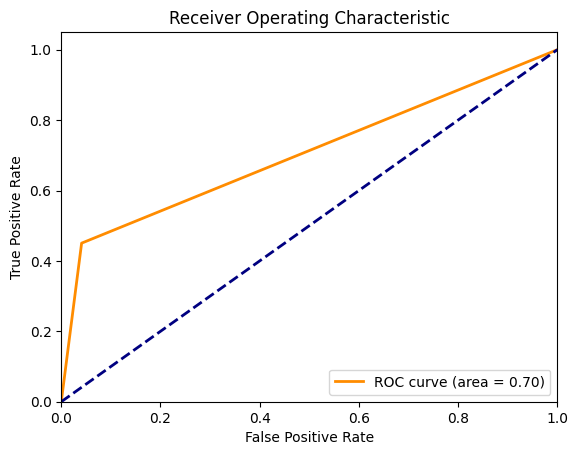

In [55]:
accuracy = accuracy_score(WAy_test, predict4)
precision = precision_score(WAy_test, predict4)
recall = recall_score(WAy_test, predict4)
fonescore = f1_score(WAy_test, predict4)
roc_auc = roc_auc_score(WAy_test, predict4)

print("Accuracy: "+str(accuracy))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("F1 Score: "+str(fonescore))
print("ROC AUC: "+str(roc_auc))

fpr, tpr, thresholds = roc_curve(WAy_test, predict4)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# **Gridsearch KNN - Notas**

# **Métricas KNN - Notas**

# **Gridsearch KNN - Escogido**

# **Métricas KNN - Escogido**

# **Gridsearch Logit - WeatherAUS**

# **Métricas Logit - WeatherAUS**

# **Gridsearch Logit - Notas**

# **Métricas Logit - Notas**

# **Gridsearch Logit - Escogido**

# **Métricas Logit - Escogido**

# **Gridsearch Árbol - WeatherAUS**

# **Métricas Árbol - WeatherAUS**

# **Gridsearch Árbol - Notas**

# **Métricas Árbol - Notas**

# **Gridsearch Árbol - Escogido**

# **Métricas Árbol - Escogido**